In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from attention_3 import AttentionLayer

In [2]:
data = pd.read_csv('Reviews.csv'); data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [3]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na
print(f"No of datapoints after dropping duplicates and NA Values is {len(data)}.")#checking number of remaining datapoints

No of datapoints after dropping duplicates and NA Values is 393565.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393565 non-null  int64 
 1   ProductId               393565 non-null  object
 2   UserId                  393565 non-null  object
 3   ProfileName             393565 non-null  object
 4   HelpfulnessNumerator    393565 non-null  int64 
 5   HelpfulnessDenominator  393565 non-null  int64 
 6   Score                   393565 non-null  int64 
 7   Time                    393565 non-null  int64 
 8   Summary                 393565 non-null  object
 9   Text                    393565 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


In [5]:
print(data.loc[:,'Text'][0])
print(data.loc[:,'Summary'][0])

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Good Quality Dog Food


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'it', 'against', 'shan', 'more', 'while', 'such', "don't", 'couldn', "she's", 'before', 've', 'a', 'don', 'wouldn', "hasn't", 'few', "you'd", 'her', 'what', 'i', 'shouldn', 'into', 'wasn', 'she', 'his', 'very', "isn't", 'which', 'them', 'him', 'ain', 'now', 'myself', 'those', 'up', 'are', 'my', 'why', 'isn', 's', 'with', 'can', 'because', 'these', 'they', 'in', 'other', 'hasn', 'once', 'where', 'only', 'me', 'you', "you've", 'hadn', 'and', 'hers', 'own', 'but', "wasn't", 'same', 'here', 'yourself', 'the', 'weren', 'so', 'am', 'o', 'll', 'yourselves', 'all', 'themselves', 'than', 'aren', 'ours', 'no', 'as', "aren't", 'about', "mustn't", 'does', 'each', 'most', 'did', 'he', 't', 'their', 'haven', 'we', 'ourselves', 'further', 'mustn', 'y', 'again', 'has', 'yours', 'nor', 'being', 'just', 'should', "shan't", 'is', 'won', 'whom', 'doesn', 'this', 'its', 'mightn', "shouldn't", 'below', 'of', 'over', 'off', 'didn', 'to', 'after', "needn't", 'at', 'himself', 'or', 'been', 'd', 'an', 'our', '

[nltk_data] Downloading package stopwords to /home/sysadm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def cleaner(text,num):
    newString = text.lower()                                                                                                 #Converting everything to lowercase
    #newString = BeautifulSoup(newString, "lxml").text                                                                        #Remove XML & HTML tags
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])          #Expanding Contractions
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]                                                      #removing stopwords
    else:
        tokens=newString.split()
        
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                                                                        #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [9]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(cleaner(t,0))

In [10]:
print(data.loc[:,'Text'][0])
print(cleaned_text[:1])  

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better']


In [11]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(cleaner(t,1))

In [12]:
print(data.loc[:,'Summary'][0])
print(cleaned_summary[:1])

Good Quality Dog Food
['good quality dog food']


In [13]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
print(data.loc[:,'Text'][0])
print(data.loc[:,'cleaned_text'][0])
print(data.loc[:,'Summary'][0])
print(data.loc[:,'cleaned_summary'][0])

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Good Quality Dog Food
good quality dog food


In [14]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...,not as advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,delight says it all
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,great taffy


In [15]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [16]:
len(data)

393217

In [17]:
from matplotlib.pyplot import figure

<Figure size 640x480 with 0 Axes>

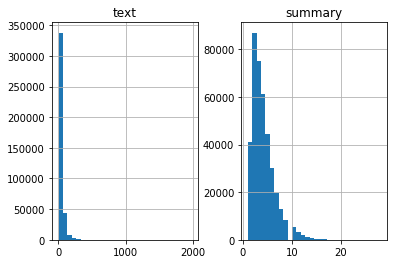

In [18]:
import matplotlib.pyplot as plt
figure(figsize=(8, 6), dpi=80)
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [19]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=40):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.6830121790258306


In [20]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9457805740850472


In [21]:
max_text_len=25
max_summary_len=8

In [22]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})
df

,text,summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,looking secret ingredient robitussin believe f...,cough medicine
3,great taffy great price wide assortment yummy ...,great taffy
4,taffy good soft chewy flavors amazing would de...,wonderful tasty taffy
...,...,...
176252,complaint much use huge amount spice gave jar ...,very large ground spice jars
176253,great sesame chicken good better resturants ea...,will not do without
176254,disappointed flavor chocolate notes especially...,disappointed
176255,best treats training rewarding dog good groomi...,favorite training and reward treat


In [23]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok'); df

,text,summary
0,bought several vitality canned dog food produc...,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts p...,sostok not as advertised eostok
2,looking secret ingredient robitussin believe f...,sostok cough medicine eostok
3,great taffy great price wide assortment yummy ...,sostok great taffy eostok
4,taffy good soft chewy flavors amazing would de...,sostok wonderful tasty taffy eostok
...,...,...
176252,complaint much use huge amount spice gave jar ...,sostok very large ground spice jars eostok
176253,great sesame chicken good better resturants ea...,sostok will not do without eostok
176254,disappointed flavor chocolate notes especially...,sostok disappointed eostok
176255,best treats training rewarding dog good groomi...,sostok favorite training and reward treat eostok


In [24]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),
                                       test_size=0.1,random_state=0,shuffle=False)

In [25]:
list(x_tr)[0]

'bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [26]:
len(x_tr[0])

164

In [27]:
list(y_tr)[0]

'sostok good quality dog food eostok'

In [28]:
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for text on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [29]:
x_tokenizer.word_counts.items()

odict_items([('bought', 8299), ('several', 2324), ('vitality', 16), ('canned', 805), ('dog', 6254), ('food', 8099), ('products', 3521), ('found', 7101), ('good', 37651), ('quality', 5324), ('product', 28922), ('looks', 944), ('like', 30930), ('stew', 102), ('processed', 277), ('meat', 1007), ('smells', 1175), ('better', 10190), ('labrador', 39), ('finicky', 206), ('appreciates', 24), ('arrived', 4417), ('labeled', 109), ('jumbo', 58), ('salted', 258), ('peanuts', 597), ('actually', 2215), ('small', 3445), ('sized', 366), ('unsalted', 79), ('sure', 3257), ('error', 76), ('vendor', 511), ('intended', 91), ('represent', 14), ('looking', 3427), ('secret', 125), ('ingredient', 564), ('robitussin', 2), ('believe', 1090), ('got', 5385), ('addition', 709), ('root', 213), ('beer', 365), ('extract', 417), ('ordered', 5752), ('made', 5519), ('cherry', 664), ('soda', 793), ('flavor', 21529), ('medicinal', 68), ('great', 40417), ('taffy', 213), ('price', 15617), ('wide', 117), ('assortment', 304), 

In [30]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("% of Total Coverage of rare words:",(freq/tot_freq)*100)
print(freq)
print(tot_freq)

% of rare words in vocabulary: 65.42756117986414
% of Total Coverage of rare words: 1.5056613004457011
38839
2579531


In [31]:
#prepare a tokenizer for text on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [32]:
x_voc

14863

In [33]:
#prepare a tokenizer for summary on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [34]:
x_tokenizer.word_counts.items()

odict_items([('bought', 8299), ('several', 2324), ('vitality', 16), ('canned', 805), ('dog', 6254), ('food', 8099), ('products', 3521), ('found', 7101), ('good', 37651), ('quality', 5324), ('product', 28922), ('looks', 944), ('like', 30930), ('stew', 102), ('processed', 277), ('meat', 1007), ('smells', 1175), ('better', 10190), ('labrador', 39), ('finicky', 206), ('appreciates', 24), ('arrived', 4417), ('labeled', 109), ('jumbo', 58), ('salted', 258), ('peanuts', 597), ('actually', 2215), ('small', 3445), ('sized', 366), ('unsalted', 79), ('sure', 3257), ('error', 76), ('vendor', 511), ('intended', 91), ('represent', 14), ('looking', 3427), ('secret', 125), ('ingredient', 564), ('robitussin', 2), ('believe', 1090), ('got', 5385), ('addition', 709), ('root', 213), ('beer', 365), ('extract', 417), ('ordered', 5752), ('made', 5519), ('cherry', 664), ('soda', 793), ('flavor', 21529), ('medicinal', 68), ('great', 40417), ('taffy', 213), ('price', 15617), ('wide', 117), ('assortment', 304), 

In [35]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("% of Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 69.19507984462668
% of Total Coverage of rare words: 2.153417691753744


In [36]:
#prepare a tokenizer for summary on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [37]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(158631, 158631)

In [38]:
y_voc

5711

In [39]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [40]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [42]:
from keras import backend as K 

In [43]:
K.clear_session()

latent_dim = 200
embedding_dim = 300

# Encoder
encoder_inputs = Input(shape = (max_text_len, ))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences = True, return_state = True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim, return_sequences = True, return_state = True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3 = LSTM(latent_dim, return_state = True, return_sequences = True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape = (None, ))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state = [state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis = -1,name = 'concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation = 'softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4458900     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 25, 200), (N 400800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [44]:
model.compile(optimizer = 'rmsprop', loss ='sparse_categorical_crossentropy', metrics = ['acc'])

In [45]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)

In [46]:
history=model.fit([x_tr, y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
                  epochs = 50,
                  callbacks = [es],
                  batch_size = 128, 
                  validation_split = 0.1)

Epoch 1/50
1101/1101 [==============================] - 434s 389ms/step - loss: 2.6829 - acc: 0.5996 - val_loss: 2.4280 - val_acc: 0.6249
Epoch 2/50
1101/1101 [==============================] - 426s 387ms/step - loss: 2.3289 - acc: 0.6302 - val_loss: 2.2730 - val_acc: 0.6409
Epoch 3/50
1101/1101 [==============================] - 426s 387ms/step - loss: 2.2035 - acc: 0.6420 - val_loss: 2.1960 - val_acc: 0.6481
Epoch 4/50
1101/1101 [==============================] - 426s 387ms/step - loss: 2.1210 - acc: 0.6498 - val_loss: 2.1536 - val_acc: 0.6511
Epoch 5/50
1101/1101 [==============================] - 426s 386ms/step - loss: 2.0602 - acc: 0.6550 - val_loss: 2.1246 - val_acc: 0.6541
Epoch 6/50
1101/1101 [==============================] - 426s 387ms/step - loss: 2.0185 - acc: 0.6595 - val_loss: 2.1104 - val_acc: 0.6561
Epoch 7/50
1101/1101 [==============================] - 424s 385ms/step - loss: 1.9757 - acc: 0.6635 - val_loss: 2.1040 - val_acc: 0.6552
Epoch 8/50
1101/1101 [============

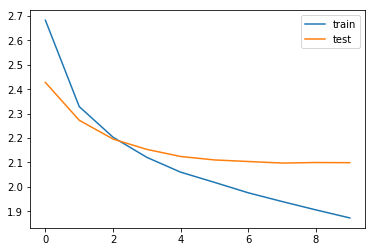

In [47]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [48]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word

target_word_index=y_tokenizer.word_index

In [49]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape = (latent_dim, ))
decoder_state_input_c = Input(shape = (latent_dim, ))
decoder_hidden_state_input = Input(shape = (max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

#Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis = -1, name = 'concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [50]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ""
    
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += sampled_token + " "

        # Exit condition: either hit max length or find stop word.
        if(sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [51]:
def seq2summary(input_seq):
    newString = ""
    for i in input_seq:
        if((i != 0 and i!= target_word_index['sostok']) and i!= target_word_index['eostok']):
            newString += reverse_target_word_index[i] + " "
    return newString

def seq2text(input_seq):
    newString = ""
    for i in input_seq:
        if(i != 0):
            newString += reverse_source_word_index[i] + " "
    return newString

In [52]:
from scipy import spatial
import gensim.downloader as api

In [53]:
model = api.load("glove-wiki-gigaword-50")

def preprocess(s):
    return [i.lower() for i in s.split()]

def get_vector(s):
    return np.sum(np.array([model[i] for i in preprocess(s)]), axis=0)

In [60]:
rand_ind = np.random.randint(0, 500000, size = 5000)
cnt = 0
tot_sim  = 0

In [61]:
for i in rand_ind:
    try:
        #print("Review:", seq2text(x_tr[i]))
        og_sum = seq2summary(y_tr[i])
        op_sum = decode_sequence(x_tr[i].reshape(1,max_text_len))
        sim = 1 - spatial.distance.cosine(get_vector(og_sum), get_vector(op_sum))
        sim = abs(sim)
        tot_sim = tot_sim + sim
        cnt = cnt + 1
        print("Original summary:", og_sum)
        print("Predicted summary:", op_sum)
        print("Semantic Similarity:", sim)      
        print("\n")
    except:
        continue

Original summary: best soda ever 
Predicted summary: sugar free 
Semantic Similarity: 0.7666078805923462


Original summary: do not buy 
Predicted summary: terrible 
Semantic Similarity: 0.4691981375217438


Original summary: picky eater 
Predicted summary: my dog loves these 
Semantic Similarity: 0.3020513355731964


Original summary: satisfied and pleased 
Predicted summary: nice tea 
Semantic Similarity: 0.5677645206451416


Original summary: kellogg special pastry 
Predicted summary: good but expensive 
Semantic Similarity: 0.46682220697402954


Original summary: great 
Predicted summary: great bars 
Semantic Similarity: 0.8124669790267944


Original summary: eh 
Predicted summary: not good 
Semantic Similarity: 0.048345450311899185


Original summary: best cold 
Predicted summary: delicious 
Semantic Similarity: 0.5129086971282959


Original summary: not spicy 
Predicted summary: great chili 
Semantic Similarity: 0.7968514561653137


Original summary: yum for your cup 
Predicted s

Original summary: happy to find these for great price 
Predicted summary: love this candy 
Semantic Similarity: 0.8480051159858704


Original summary: not so much candy 
Predicted summary: not as advertised 
Semantic Similarity: 0.9223374128341675


Original summary: swedish fish assorted candy 
Predicted summary: great for fish 
Semantic Similarity: 0.7410289645195007


Original summary: good stuff 
Predicted summary: great for the price 
Semantic Similarity: 0.7563357949256897


Original summary: yum 
Predicted summary: delicious 
Semantic Similarity: 0.18168184161186218


Original summary: only salt for me 
Predicted summary: great salt 
Semantic Similarity: 0.8357696533203125


Original summary: fantastic tea 
Predicted summary: great tea 
Semantic Similarity: 0.8817257881164551


Original summary: spicy 
Predicted summary: good 
Semantic Similarity: 0.3568727970123291


Original summary: slightly disappointed 
Predicted summary: not what expected 
Semantic Similarity: 0.7383455038

Original summary: the only taco seasoning use 
Predicted summary: best seasoning ever 
Semantic Similarity: 0.8361033201217651


Original summary: good flavor 
Predicted summary: good 
Semantic Similarity: 0.8681115508079529


Original summary: bigelow raspberry tea 
Predicted summary: great product 
Semantic Similarity: 0.3316434919834137


Original summary: not so hot 
Predicted summary: not good 
Semantic Similarity: 0.9376856684684753


Original summary: really good 
Predicted summary: delicious 
Semantic Similarity: 0.49441877007484436


Original summary: best popcorn ever 
Predicted summary: great popcorn 
Semantic Similarity: 0.8663930892944336


Original summary: love this seasoning 
Predicted summary: great seasoning 
Semantic Similarity: 0.8775100708007812


Original summary: coffee 
Predicted summary: best coffee ever 
Semantic Similarity: 0.6985406279563904


Original summary: great taste 
Predicted summary: great taste 
Semantic Similarity: 1


Original summary: delicious 

Original summary: tastes just like 
Predicted summary: good tea 
Semantic Similarity: 0.8388489484786987


Original summary: costs too much 
Predicted summary: good product but expensive 
Semantic Similarity: 0.9301105737686157


Original summary: done with diamond 
Predicted summary: terrible 
Semantic Similarity: 0.43030107021331787


Original summary: the that does not break the bank 
Predicted summary: the best 
Semantic Similarity: 0.8853222727775574


Original summary: best earl grey tea 
Predicted summary: best tea ever 
Semantic Similarity: 0.795235276222229


Original summary: good soup 
Predicted summary: great gift 
Semantic Similarity: 0.7292488217353821


Original summary: love this coffee 
Predicted summary: love this coffee 
Semantic Similarity: 1


Original summary: excellent 
Predicted summary: great snack 
Semantic Similarity: 0.6395272016525269


Original summary: very happy with this product 
Predicted summary: delicious 
Semantic Similarity: 0.4616774022579193


Or

Original summary: never 
Predicted summary: not as advertised 
Semantic Similarity: 0.8484860062599182


Original summary: mini jade plant 
Predicted summary: great 
Semantic Similarity: 0.3933258652687073


Original summary: great product 
Predicted summary: best price 
Semantic Similarity: 0.8372250199317932


Original summary: gets you going 
Predicted summary: great snack 
Semantic Similarity: 0.6695960760116577


Original summary: as close as it can get 
Predicted summary: best tea ever 
Semantic Similarity: 0.8248593211174011


Original summary: great taste 
Predicted summary: very tasty 
Semantic Similarity: 0.7949533462524414


Original summary: nutty 
Predicted summary: good 
Semantic Similarity: 0.3591594696044922


Original summary: good flavor for price 
Predicted summary: good coffee 
Semantic Similarity: 0.8991017937660217


Original summary: pretty good instant coffee am impressed 
Predicted summary: good for the price 
Semantic Similarity: 0.8123058080673218


Original 

Original summary: not very good 
Predicted summary: good product 
Semantic Similarity: 0.8891395926475525


Original summary: love it 
Predicted summary: great for milk 
Semantic Similarity: 0.8379442691802979


Original summary: not what expected 
Predicted summary: not what expected 
Semantic Similarity: 1


Original summary: great coffee 
Predicted summary: great coffee 
Semantic Similarity: 1


Original summary: my breakfast food 
Predicted summary: best tasting bread ever 
Semantic Similarity: 0.8492067456245422


Original summary: not very good toffee 
Predicted summary: not so good 
Semantic Similarity: 0.9326538443565369


Original summary: sweet with kick 
Predicted summary: great taste 
Semantic Similarity: 0.7524661421775818


Original summary: its my favorite 
Predicted summary: love this gum 
Semantic Similarity: 0.8620085716247559


Original summary: taste bad 
Predicted summary: not good 
Semantic Similarity: 0.8048250675201416


Original summary: food allergies can happ

Original summary: grandchildren love these 
Predicted summary: great for the price 
Semantic Similarity: 0.6744314432144165


Original summary: cats loved it but packaging up fight 
Predicted summary: cats love it 
Semantic Similarity: 0.9265590310096741


Original summary: ferrara torrone 
Predicted summary: great value 
Semantic Similarity: 0.20982947945594788


Original summary: so good 
Predicted summary: good 
Semantic Similarity: 0.9698854088783264


Original summary: the best 
Predicted summary: great product 
Semantic Similarity: 0.857154905796051


Original summary: lots of twizzlers just what you expect 
Predicted summary: great product 
Semantic Similarity: 0.827593207359314


Original summary: dented cans 
Predicted summary: dented cans 
Semantic Similarity: 1


Original summary: delicious 
Predicted summary: delicious 
Semantic Similarity: 1


Original summary: love this coffee 
Predicted summary: great coffee 
Semantic Similarity: 0.9067448973655701


Original summary: gr

Original summary: great chocolate 
Predicted summary: chocolate 
Semantic Similarity: 0.7996218204498291


Original summary: diarrhea and such 
Predicted summary: cats love it 
Semantic Similarity: 0.7060208916664124


Original summary: organic and delicious lemon juice 
Predicted summary: great product 
Semantic Similarity: 0.5955921411514282


Original summary: unsatisfied 
Predicted summary: not worth the money 
Semantic Similarity: 0.02067313902080059


Original summary: good quality vanilla syrup 
Predicted summary: good syrup 
Semantic Similarity: 0.9657621383666992


Original summary: very disappointed 
Predicted summary: never again 
Semantic Similarity: 0.8016132116317749


Original summary: great dark chocolat 
Predicted summary: great dark chocolate 
Semantic Similarity: 0.8472565412521362


Original summary: not labeled properly 
Predicted summary: not as advertised 
Semantic Similarity: 0.8879861831665039


Original summary: love it 
Predicted summary: my cats love this 
S

Original summary: fantastic 
Predicted summary: delicious 
Semantic Similarity: 0.46757781505584717


Original summary: would buy again 
Predicted summary: great coffee 
Semantic Similarity: 0.6601709723472595


Original summary: bold smooth 
Predicted summary: great coffee 
Semantic Similarity: 0.4746669828891754


Original summary: good cream of wheat 
Predicted summary: great value 
Semantic Similarity: 0.7362473607063293


Original summary: overpriced and bad taste 
Predicted summary: not good 
Semantic Similarity: 0.8213320374488831


Original summary: our dog loves them 
Predicted summary: great product 
Semantic Similarity: 0.7386593818664551


Original summary: hated them 
Predicted summary: not what expected 
Semantic Similarity: 0.747378408908844


Original summary: best salad dressing 
Predicted summary: great tasting 
Semantic Similarity: 0.7532464265823364


Original summary: davidson rooibos oz bulk tea 
Predicted summary: delicious 
Semantic Similarity: 0.511931300163269

Original summary: so 
Predicted summary: love these 
Semantic Similarity: 0.8648439049720764


Original summary: pricey but delicious 
Predicted summary: yummy 
Semantic Similarity: 0.2630373239517212


Original summary: too tasty 
Predicted summary: love this stuff 
Semantic Similarity: 0.7740088105201721


Original summary: terrible disappointment 
Predicted summary: terrible 
Semantic Similarity: 0.9038199782371521


Original summary: great flavor 
Predicted summary: good 
Semantic Similarity: 0.7975993752479553


Original summary: yes 
Predicted summary: love these mints 
Semantic Similarity: 0.617375910282135


Original summary: buffalo bills smokies 
Predicted summary: good but not great 
Semantic Similarity: 0.38275161385536194


Original summary: my dogs love this 
Predicted summary: great for dogs with allergies 
Semantic Similarity: 0.8881629705429077


Original summary: great healthy treat 
Predicted summary: my dog loves these 
Semantic Similarity: 0.822296142578125


Origi

Original summary: way too hot and like hot 
Predicted summary: love this stuff 
Semantic Similarity: 0.899321436882019


Original summary: red rice 
Predicted summary: excellent 
Semantic Similarity: 0.4889259934425354


Original summary: kids love it not low sugar 
Predicted summary: yummy 
Semantic Similarity: 0.04413977265357971


Original summary: tastes good bad texture 
Predicted summary: not so good 
Semantic Similarity: 0.8165546655654907


Original summary: wonderful variety of 
Predicted summary: delicious 
Semantic Similarity: 0.5501309037208557


Original summary: always perfect 
Predicted summary: love this stuff 
Semantic Similarity: 0.9135410189628601


Original summary: smokey bbq pork rinds 
Predicted summary: good 
Semantic Similarity: 0.16639257967472076


Original summary: my kids love these 
Predicted summary: great 
Semantic Similarity: 0.733404278755188


Original summary: product and service wonderful 
Predicted summary: good product 
Semantic Similarity: 0.9211

Original summary: wonderful flour from or 
Predicted summary: great product 
Semantic Similarity: 0.7984625101089478


Original summary: good for 
Predicted summary: good but pricey 
Semantic Similarity: 0.9144195318222046


Original summary: satisfying taste 
Predicted summary: delicious 
Semantic Similarity: 0.816144585609436


Original summary: addictively good 
Predicted summary: best cookies ever 
Semantic Similarity: 0.6673930287361145


Original summary: delicious coffee 
Predicted summary: great coffee 
Semantic Similarity: 0.7756001353263855


Original summary: chocolate 
Predicted summary: chocolate 
Semantic Similarity: 1


Original summary: very nice beans very affordable 
Predicted summary: great beans 
Semantic Similarity: 0.801953136920929


Original summary: great for diabetics 
Predicted summary: great product 
Semantic Similarity: 0.8356917500495911


Original summary: pure caffeine eye cream 
Predicted summary: amazing 
Semantic Similarity: 0.3889826238155365


Origi

Original summary: love this great taste 
Predicted summary: great product 
Semantic Similarity: 0.8886638879776001


Original summary: not very good 
Predicted summary: not good 
Semantic Similarity: 0.9898310899734497


Original summary: long wait 
Predicted summary: excellent 
Semantic Similarity: 0.5040848851203918


Original summary: oatmeal bars 
Predicted summary: great for kids 
Semantic Similarity: 0.381817102432251


Original summary: yummy gummi 
Predicted summary: great price 
Semantic Similarity: 0.12474191188812256


Original summary: good taste 
Predicted summary: great 
Semantic Similarity: 0.734699010848999


Original summary: great summer tea 
Predicted summary: great taste 
Semantic Similarity: 0.8459429740905762


Original summary: and fry 
Predicted summary: good product 
Semantic Similarity: 0.6425508260726929


Original summary: not for the weak of tooth 
Predicted summary: delicious 
Semantic Similarity: 0.24959200620651245


Original summary: favorite bar 
Predi

Original summary: great size great bag great candy 
Predicted summary: great for the price 
Semantic Similarity: 0.8588920831680298


Original summary: pretty good 
Predicted summary: great taste 
Semantic Similarity: 0.7938267588615417


Original summary: sheets 
Predicted summary: great product 
Semantic Similarity: 0.325975626707077


Original summary: mm gummy 
Predicted summary: good 
Semantic Similarity: 0.038182251155376434


Original summary: great tea sampler in gift box 
Predicted summary: great tea 
Semantic Similarity: 0.8703762292861938


Original summary: good flavor little strong 
Predicted summary: good coffee 
Semantic Similarity: 0.8546550869941711


Original summary: not the original 
Predicted summary: not what expected 
Semantic Similarity: 0.8713189363479614


Original summary: full bodied and bold 
Predicted summary: good coffee 
Semantic Similarity: 0.6772547364234924


Original summary: campbells chunky soup oz cans 
Predicted summary: great product 
Semantic S

Original summary: flavorful rich delicious 
Predicted summary: best tasting 
Semantic Similarity: 0.67061448097229


Original summary: natural soda 
Predicted summary: not so good 
Semantic Similarity: 0.5332536101341248


Original summary: very hard 
Predicted summary: not good 
Semantic Similarity: 0.939365565776825


Original summary: very good decaf coffee 
Predicted summary: not good 
Semantic Similarity: 0.8094645738601685


Original summary: excellent 
Predicted summary: delicious 
Semantic Similarity: 0.4572945833206177


Original summary: moldy 
Predicted summary: expired 
Semantic Similarity: 0.05239987373352051


Original summary: great tasting tea 
Predicted summary: good tea 
Semantic Similarity: 0.9257867932319641


Original summary: best aloe drink ever 
Predicted summary: not good 
Semantic Similarity: 0.8070831298828125


Original summary: my brother likes it 
Predicted summary: good coffee 
Semantic Similarity: 0.7710266709327698


Original summary: wonderful taste 
P

Original summary: great product and great price 
Predicted summary: great product 
Semantic Similarity: 0.9702399969100952


Original summary: baby food 
Predicted summary: great food 
Semantic Similarity: 0.8091980218887329


Original summary: delicious caviar 
Predicted summary: delicious 
Semantic Similarity: 0.8571694493293762


Original summary: moist with heavy rum taste 
Predicted summary: not what expected 
Semantic Similarity: 0.5319827198982239


Original summary: rabbit treats 
Predicted summary: great training treats 
Semantic Similarity: 0.4859451651573181


Original summary: love it 
Predicted summary: great coffee 
Semantic Similarity: 0.7475594282150269


Original summary: the best flavor 
Predicted summary: best ever 
Semantic Similarity: 0.8587295413017273


Original summary: high fructose corn syrup 
Predicted summary: not worth the price 
Semantic Similarity: 0.44427886605262756


Original summary: my puppies love these 
Predicted summary: my puppy loves these 
Sema

Original summary: wonderful 
Predicted summary: great mints 
Semantic Similarity: 0.5489844083786011


Original summary: yummy cacao powder 
Predicted summary: great product 
Semantic Similarity: 0.1332307904958725


Original summary: love it 
Predicted summary: great for the price 
Semantic Similarity: 0.8425623178482056


Original summary: not only kids love dinosaurs 
Predicted summary: my dog loves these 
Semantic Similarity: 0.9327905178070068


Original summary: substantial delicious 
Predicted summary: delicious 
Semantic Similarity: 0.7822562456130981


Original summary: great chocolate 
Predicted summary: great 
Semantic Similarity: 0.7725493907928467


Original summary: mom loved them 
Predicted summary: good 
Semantic Similarity: 0.7868547439575195


Original summary: very pleased 
Predicted summary: great 
Semantic Similarity: 0.6706109046936035


Original summary: love 
Predicted summary: great 
Semantic Similarity: 0.7290539741516113


Original summary: great little treat

Original summary: stash orange spice tea 
Predicted summary: great tea 
Semantic Similarity: 0.6905937790870667


Original summary: disappointed 
Predicted summary: not what expected 
Semantic Similarity: 0.705870509147644


Original summary: pure 
Predicted summary: delicious 
Semantic Similarity: 0.48691755533218384


Original summary: cheese snacks 
Predicted summary: great snack 
Semantic Similarity: 0.68496173620224


Original summary: bit disappointing 
Predicted summary: not so good 
Semantic Similarity: 0.7374598979949951


Original summary: wow 
Predicted summary: good stuff 
Semantic Similarity: 0.5290005803108215


Original summary: miracle noodle 
Predicted summary: good 
Semantic Similarity: 0.4487498104572296


Original summary: very effective 
Predicted summary: not the best 
Semantic Similarity: 0.8263740539550781


Original summary: great taste and better price online 
Predicted summary: great taste 
Semantic Similarity: 0.8405088782310486


Original summary: the rolls

Original summary: raw food 
Predicted summary: great 
Semantic Similarity: 0.4396621882915497


Original summary: best gummy bears out there 
Predicted summary: best gummy bears ever 
Semantic Similarity: 0.9440232515335083


Original summary: my dog likes them 
Predicted summary: good dog food 
Semantic Similarity: 0.8910539150238037


Original summary: bisquick 
Predicted summary: great product 
Semantic Similarity: 0.035593558102846146


Original summary: dogs love em 
Predicted summary: good treats 
Semantic Similarity: 0.7157444357872009


Original summary: cannot be beat 
Predicted summary: best canned salmon 
Semantic Similarity: 0.5461719036102295


Original summary: amazing 
Predicted summary: great wine 
Semantic Similarity: 0.5378530025482178


Original summary: tastes so good 
Predicted summary: love this stuff 
Semantic Similarity: 0.9045426845550537


Original summary: good treat 
Predicted summary: my dogs love these 
Semantic Similarity: 0.874357283115387


Original sum

Original summary: versatile snack 
Predicted summary: great breakfast 
Semantic Similarity: 0.5631316900253296


Original summary: love this 
Predicted summary: love this stuff 
Semantic Similarity: 0.9689876437187195


Original summary: change is not always good 
Predicted summary: not the best 
Semantic Similarity: 0.9431153535842896


Original summary: yuck 
Predicted summary: not so good 
Semantic Similarity: 0.029149310663342476


Original summary: harney sons organic silk teabags 
Predicted summary: delicious 
Semantic Similarity: 0.48031720519065857


Original summary: uses 
Predicted summary: great 
Semantic Similarity: 0.495159387588501


Original summary: great flavor super sweet 
Predicted summary: great for the price 
Semantic Similarity: 0.714722216129303


Original summary: good stuff 
Predicted summary: good stuff 
Semantic Similarity: 1


Original summary: love this stuff 
Predicted summary: best ever 
Semantic Similarity: 0.8534197807312012


Original summary: great ki

Original summary: great super nutritious raw snack 
Predicted summary: great taste 
Semantic Similarity: 0.798289954662323


Original summary: best ever vanilla 
Predicted summary: best vanilla syrup ever 
Semantic Similarity: 0.9385892152786255




In [63]:
avg_sim = tot_sim/cnt

In [64]:
print("The average semantic similarity between the actual summaries and the generated summaries are: ", avg_sim)

The average semantic similarity between the actual summaries and the generated summaries are:  0.6913427883907872
